In [1]:
import torch
import os
import PATH
import copy
import utils
import numpy as np
from tqdm.notebook import tqdm
from models import reader
from models.popen import Auto_popen
from sklearn.metrics import r2_score
import ipynb.analysis_for_MTL as A_MTL
from scipy import stats

/ssd/users/wergillius/Project/UTR_VAE


In [2]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
os.getpid()

4157

# function

In [258]:
def reload_model(config_file, device, kfold_index):
    config_file = os.path.join("/ssd/users/wergillius/Project/UTR_VAE/", config_file)
    
    POPEN  = Auto_popen(config_file)
    if kfold_index is None:
        check_point = torch.load(POPEN.vae_pth_path, map_location=device)
    else:
        check_point = torch.load(
            POPEN.vae_pth_path.replace('.pth', '_cv%d.pth'%kfold_index),
            map_location=device)
        
    model = check_point['state_dict'].to(device)
    return model

def val_a_epoch(model, dataloader, device):
    y_true_ls = []
    y_pred_ls = []
    
    model.eval()
    with torch.no_grad():
        for X,Y in tqdm(dataloader):
            X = X.float().to(device)
            y_true_ls.append(Y.cpu().numpy())

            y_pred = model(X)
            y_pred_ls.append(y_pred.cpu().numpy())
    
    y_true_f = np.concatenate( y_true_ls).flatten()
    y_pred_f = np.concatenate( y_pred_ls).flatten()
    
    return y_true_f, y_pred_f

def kfold_load_data(config_file, device, kfold_index, label_uAUG=False ,expand_MAP=False):
    config_file = os.path.join("/ssd/users/wergillius/Project/UTR_VAE/", config_file)
    
    POPEN = Auto_popen(config_file)
    POPEN.kfold_index = kfold_index
    POPEN.shuffle = False
    if expand_MAP:
        if ('human' in POPEN.cycle_set) or ('SubHuman' in POPEN.cycle_set):
            POPEN.cycle_set = set(POPEN.cycle_set+['vleng','unmod1'])
    
    loader_set = {}
    base_path = copy.copy(POPEN.split_like_paper)
    base_csv = copy.copy(POPEN.csv_path)
    # for subset in POPEN.cycle_set:
    #     if base_path is not None:
    #         POPEN.split_like_paper = [path.replace('cycle', subset) for path in base_path]
    #     else:
    #         POPEN.csv_path = base_csv.replace('cycle', subset)
    #     loader_set[subset] = reader.get_dataloader(POPEN)
        
    for subset in POPEN.cycle_set:
        if (subset in ['unmod1', 'human', 'vleng', 'SubHuman','SubVleng','SubUnmod1']):
            datapopen = Auto_popen('/ssd/users/wergillius/Project/UTR_VAE/log/Backbone/RL_hard_share/3M/rl_train_val_10fold/schedule_lr.ini')
            datapopen.split_like_paper = [path.replace('cycle', subset) for path in base_path]
            datapopen.kfold_index = kfold_index
            datapopen.shuffle = False
            if label_uAUG:
                datapopen.aux_task_columns += ['with_uAUG']
            loader_set[subset] = reader.get_dataloader(datapopen)
            
        elif (subset in ['Andrev2015', 'muscle', 'pc3']):
            datapopen = Auto_popen('/ssd/users/wergillius/Project/UTR_VAE/log/Backbone/RL_hard_share/3R/schedule_MTL.ini')
            datapopen.csv_path = base_csv.replace('cycle', subset)
            datapopen.kfold_index = kfold_index
            datapopen.shuffle = False
            if label_uAUG:
                datapopen.aux_task_columns += ['with_uAUG']
            loader_set[subset] = reader.get_dataloader(datapopen)
        
    return loader_set


def pipeline_for_RL_3_data(config_file, which_set=1, device='cpu'):
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    
    model = reload_model(config_file, device)
    
    r2_dict = {}
    for cycle in ['unmod1', 'human', 'vleng']:
        model.task = cycle # which works for normal RL_gru
        dataloader = loader_set[cycle][which_set]
        y_true_f, y_pred_f = val_a_epoch(model, dataloader, device)
        r2_dict[cycle] = A_MTL.compute_r2(y_true_f,y_pred_f) , r2_score(y_true_f,y_pred_f)
    
    del model
    
    return r2_dict

In [259]:
def pipeline_cell_line(config_file, which_set=2, device='cpu', kfold_index=None, expand_MAP=False, label_uAUG=False):
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    
    loader_set = kfold_load_data(config_file, device, kfold_index, label_uAUG=label_uAUG, expand_MAP=expand_MAP)
    
    # trained tasks from popen
    config_file = os.path.join("/ssd/users/wergillius/Project/UTR_VAE/", config_file)
    model = reload_model(config_file, device, kfold_index)
    popen = Auto_popen(config_file)
    trained_task = popen.cycle_set
    
    # iter tasks
    r2_dict = {}
    spr_dict = {}
    for cycle in list(loader_set.keys()):
        model.task = cycle # which works for normal RL_gru
        
        if expand_MAP:
            # use human tower to predict unmod1 or vleng
            if (cycle in ['vleng', 'unmod1']) and (model.task not in trained_task):
                model.task = 'human' if 'human'  in trained_task else 'SubHuman'
                
        dataloader = loader_set[cycle][which_set]
        y_true_f, y_pred_f = val_a_epoch(model, dataloader, device)
        spr_dict[cycle] = stats.spearmanr(y_true_f, y_pred_f)[0]
        r2_dict[cycle] = r2_score(y_true_f, y_pred_f)
    del model
    
    return r2_dict,spr_dict

In [260]:
def singletask_cell_line(config_file, which_set=2, device='cpu', kfold_index=None):
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    
    popen = Auto_popen("/ssd/users/wergillius/Project/UTR_VAE/"+config_file)
    popen.kfold_index = kfold_index
    dataloader = reader.get_dataloader(popen)[which_set]
    model = reload_model(config_file, device, kfold_index)
    
    
    y_true_f, y_pred_f = val_a_epoch(model, dataloader, device)
    r2 = stats.spearmanr(y_true_f, y_pred_f)[0]
    
    del model
    
    return r2

In [261]:
def testset_result( json , model_name):
    """
    convert prediction result dict in test set to seaborn favourable dataset
    
    Args:
        json : [dict]  , list of dict { 'task' : values}
        model_name : the model used to predict
    Return:
        df
    """
    tiddy_data = np.concatenate([np.stack(dic.items()) for dic in json])
    df = pd.DataFrame(tiddy_data,columns=['task','sp_r'])
    df['sp_r'] =df.sp_r.astype(float).apply(round, args=(3,))
    df['model'] = model_name
    df['R2'] = df.sp_r.apply(lambda x: x**2)
    return df

# RL 6 data

## collecting data

 order : 3 C -> 3 C 1sH-> 2 C 1SH -> 2 cellline_Human -> 2 cellline 2 sub -> 2c2M ->3C3M -> 3M

## 3C

In [45]:
C3 = pd.read_csv('FIG3_3cellline_permformance.csv')

In [47]:
C3_df = pd.DataFrame([])
for column in ['scratch_Andrev2015', 'scratch_muscle', 'scratch_pc3']:
    tmp = C3[[column]].copy().rename({column:'spr'}, axis=1)
    tmp['task'] = column
    
    C3_df = C3_df.append(tmp)
C3_df['model'] = 'RL_3_cell'
C3_df['R2'] = C3_df['spr'].values**2

In [61]:
C3_df['task'] = C3_df['task'].apply(lambda x: x.replace('scratch_', ''))

## 3C 1sH

In [49]:
SubHuman_3C = []
config_file = 'log/Backbone/RL_6_data/1M3C/SubHuman_3C_1.ini'
for i in range(4):
    SubHuman_3C.append(pipeline_cell_line(config_file, which_set=2, device = 1, kfold_index=i, expand_MAP=True))

SubHuman_3C_data = testset_result(SubHuman_3C, 'SubHuman_3C')

NameError: name 'pipeline_cell_line' is not defined

In [14]:
print(SubHuman_3C_data.task.unique())
SubHuman_3C_data.head(4)

['SubHuman' 'Andrev2015' 'vleng' 'pc3' 'muscle' 'unmod1']


,task,sp_r,model,R2
0,SubHuman,0.821,SubHuman_3C,0.674041
1,Andrev2015,0.627,SubHuman_3C,0.393129
2,vleng,0.721,SubHuman_3C,0.519841
3,pc3,0.689,SubHuman_3C,0.474721


## 2C 1SH

In [12]:
SubHuman_no_M = []
config_file = 'log/Backbone/RL_6_data/SubHuman_Andrev_pc3_10fold/SubHuman_no_muscle.ini'
for i in range(1,5):
    SubHuman_no_M.append(pipeline_cell_line(config_file, which_set=2, device=1, kfold_index=i ,expand_MAP=True))

KeyboardInterrupt: 

In [16]:
SubHuman_no_M = testset_result(SubHuman_no_M, 'SubHuman_no_M')
SubHuman_no_M['R2'] = SubHuman_no_M.sp_r.apply(lambda x: x**2)
SubHuman_no_M

/tmp/ipykernel_140998/845107373.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  SubHuman_no_M = testset_result(SubHuman_no_M, 'SubHuman_no_M')


,task,sp_r,model,R2
0,SubHuman,0.816,SubHuman_no_M,0.665856
1,Andrev2015,0.626,SubHuman_no_M,0.391876
2,vleng,0.666,SubHuman_no_M,0.443556
3,pc3,0.688,SubHuman_no_M,0.473344
4,unmod1,0.806,SubHuman_no_M,0.649636
5,SubHuman,0.800,SubHuman_no_M,0.640000
6,Andrev2015,0.633,SubHuman_no_M,0.400689
7,vleng,0.646,SubHuman_no_M,0.417316
8,pc3,0.668,SubHuman_no_M,0.446224
9,unmod1,0.796,SubHuman_no_M,0.633616


## 2C 1H

In [17]:
Human_no_M = []
config_file = 'log/Backbone/RL_6_data/task_lambda/Human_no_M.ini'
for i in range(3):
    Human_no_M.append(pipeline_cell_line(config_file, which_set=2, device=1, kfold_index=i, expand_MAP=True))
Human_nM_data =  testset_result(Human_no_M, 'Human_no_M')

100%|██████████| 625/625 [00:04<00:00, 156.13it/s]
/tmp/ipykernel_140998/1581017463.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Human_nM_data =  testset_result(Human_no_M, 'Human_no_M')


In [20]:
Human_no_M = []
config_file = 'log/Backbone/RL_6_data/1M2C/Human_no_M.ini'
for i in range(3):
    Human_no_M.append(pipeline_cell_line(config_file, which_set=2, device=1, kfold_index=i, expand_MAP=True))
Human_nM_data =  testset_result(Human_no_M, 'Human_no_M')

100%|██████████| 124/124 [00:00<00:00, 124.07it/s]
/tmp/ipykernel_253986/3207177865.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Human_nM_data =  testset_result(Human_no_M, 'Human_no_M')


In [30]:
Human_nM_data['content_of_MAP']  = 3

In [35]:
R2_mean_dict = {task:Human_nM_data[Human_nM_data.task == task].R2.mean() for task in Human_nM_data.task}

In [39]:
Human_nM_data['R2_mean'] = Human_nM_data.task.apply(lambda x: R2_mean_dict[x])

## 2C 2sub

In [23]:
S2C2 = []
config_file = 'log/Backbone/RL_6_data/task_lambda/2Sub2cell_weightpc3.ini'
for i in range(4):
    S2C2.append(pipeline_cell_line(config_file, which_set=2, device=1, kfold_index=i ,expand_MAP=True))

100%|██████████| 625/625 [00:06<00:00, 90.51it/s] 


In [26]:
S2C2_data = testset_result(S2C2, '2Sub2cell')
S2C2_data.head(3)

/tmp/ipykernel_120162/2943254853.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  S2C2_data = testset_result(S2C2, '2Sub2cell')


,task,sp_r,model,R2
0,Andrev2015,0.578,2Sub2cell,0.334084
1,pc3,-0.104,2Sub2cell,0.010816
2,SubVleng,0.807,2Sub2cell,0.651249


## 2C 1Sv 1H

In [21]:
SUH_AP = []
config_file = 'log/Backbone/RL_6_data/1M1SM2C/SUH_AP_2_reorderd.ini'
for i in range(4):
    SUH_AP.append(pipeline_cell_line(config_file, which_set=2, device = 1, kfold_index=i ,expand_MAP=True))

100%|██████████| 625/625 [00:03<00:00, 156.56it/s]


In [22]:
SUH_AP_data = testset_result(SUH_AP, 'SvH_AP')
SUH_AP_data.head(3)

/tmp/ipykernel_140998/3886795595.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  SUH_AP_data = testset_result(SUH_AP, 'SvH_AP')


,task,sp_r,model,R2
0,Andrev2015,0.599,SvH_AP,0.358801
1,SubVleng,0.821,SvH_AP,0.674041
2,vleng,0.800,SvH_AP,0.640000


## RL6

In [23]:
RL6 = []
config_file = 'log/Backbone/RL_6_data/test_run/schedule_lr.ini'
for i in range(6):
    RL6.append(pipeline_cell_line(config_file, which_set=2, device=1, kfold_index=i ,expand_MAP=True))

100%|██████████| 625/625 [00:04<00:00, 151.53it/s]


In [24]:
RL6_df = testset_result(RL6, 'RL_6_data')
RL6_df['R2'] = RL6_df.sp_r.apply(lambda x: x**2)

RL6_df.head(6)

/tmp/ipykernel_140998/1162138725.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  RL6_df = testset_result(RL6, 'RL_6_data')


,task,sp_r,model,R2
0,Andrev2015,-0.030,RL_6_data,0.000900
1,vleng,0.898,RL_6_data,0.806404
2,human,0.905,RL_6_data,0.819025
3,pc3,-0.132,RL_6_data,0.017424
4,muscle,0.106,RL_6_data,0.011236
5,unmod1,0.955,RL_6_data,0.912025


## 3MAP

In [25]:
M3 = pd.read_csv('FIG2_performance.csv')

In [26]:
M3_df = pd.DataFrame([])
for column in ['MTL_unmod1', 'MTL_human', 'MTL_vleng']:
    
    tmp_df = M3[[column]].copy().rename({column:'R2'},axis=1)
    tmp_df['task'] = column.split('_')[1]
    
    M3_df = M3_df.append(tmp_df)

In [27]:
M3_df['model'] = 'RL_3_MAP'

## integrating all

in the order of 
3 C -> 3 C 1sH-> 2 C 1SH -> 2 cellline_Human -> 2 cellline 2 sub -> 2c2M ->3C3M -> 3M

In [28]:
all_result = pd.DataFrame([])

for df in [C3_df,SubHuman_3C_data, SubHuman_no_M, Human_nM_data, S2C2_data, SUH_AP_data, RL6_df, M3_df]:
    all_result = all_result.append(df)

all_result['task'] = all_result.task.apply(lambda x : x.replace('SubHuman','human'))
all_result['task'] = all_result.task.apply(lambda x : x.replace('SubVleng','vleng'))

In [59]:
models  =  all_result.sort_index().model.unique()

In [60]:
models

array(['RL_3_cell', 'SubHuman_3C', 'SubHuman_no_M', 'Human_no_M',
       'SvH_AP', 'RL_6_data', 'RL_3_MAP', '2Sub2cell'], dtype=object)

In [61]:
models  = ['RL_3_cell', 'SubHuman_3C', 'SubHuman_no_M', 'Human_no_M', '2Sub2cell',
       'SvH_AP', 'RL_6_data', 'RL_3_MAP',]
content_dict = dict(zip(models, range(8)))
all_result['content_of_MAP'] = all_result.model.apply(lambda x: content_dict[x])

In [84]:
all_result.sort_index().to_csv("FIG3_combinatory_strategy.csv", index=False)

In [84]:
all_result.sort_index().to_csv("FIG3_combinatory_strategy.csv", index=False)

# RL hard share

## 3M

In [58]:
M3_df = pd.read_csv("FIG2_performance.csv")

In [59]:
M3_df=M3_df[[col for col in M3_df.columns if 'MTL' in col]]

In [60]:
M3_df=pd.DataFrame(M3_df.mean(axis=0).values.reshape(1,3),columns=['unmod1','human','vleng'])

In [61]:
M3_df.loc[:,'model'] = '3M'
M3_df.loc[:,'configuration'] = 'schedule_lr.ini'
M3_df.loc[:,'weigth_M/R'] = 0

M3_df.loc[:,'Andrev2015'] = np.nan
M3_df.loc[:,'pc3'] = np.nan
M3_df.loc[:,'muscle'] = np.nan

In [62]:
M3_df

,unmod1,human,vleng,model,configuration,weigth_M/R,Andrev2015,pc3,muscle
0,0.942021,0.833919,0.871195,3M,schedule_lr.ini,0,NaN,NaN,NaN


## 3MR

In [11]:
m3r_r2,m3r_spr=pipeline_cell_line(config_file = "log/Backbone/RL_hard_share/3M1R/Andrev_3M_w0.ini", 
                                      device=1,
                                      kfold_index=1)


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

In [12]:
m3r_df = pd.json_normalize(m3r_r2)
m3r_df.loc[:,'model'] = '3MR'
m3r_df.loc[:,'configuration'] = 'Andrev_3M_w0'

#{'human': 0.1, 'Andrev2015': 1, 'muscle': 1, 'pc3': 2}
m3r_df.loc[:,'weigth_M/R'] = 0.1

## 3M2R

In [9]:
m3r2_r2,m3r2_spr=pipeline_cell_line(config_file = "log/Backbone/RL_hard_share/3M2R/AP_3M_w0.ini", 
                                      device=1,
                                      kfold_index=1)

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

In [10]:

m3r2_df = pd.json_normalize(m3r2_r2)
m3r2_df.loc[:,'model'] = '3M2R'
m3r2_df.loc[:,'configuration'] = 'AP_3M_w0'


#{'human': 0.1, 'Andrev2015': 1, 'muscle': 1, 'pc3': 2}
m3r2_df.loc[:,'weigth_M/R'] = 0.1
m3r2_df = pd.json_normalize(m3r2_r2)
m3r2_df.loc[:,'model'] = '3M2R'
m3r2_df.loc[:,'configuration'] = 'AP_3M_w0'


#{'human': 0.1, 'Andrev2015': 1, 'muscle': 1, 'pc3': 2}
m3r2_df.loc[:,'weigth_M/R'] = 0.1

In [82]:
m3r2_df

,unmod1,human,vleng,Andrev2015,pc3,model,configuration,weigth_M/R
0,0.892456,0.778728,0.829803,0.37982,0.467971,3M2R,AP_3M_w0,0.1


## 3M3R

In [64]:
Allw0_r2,Allw0_spr=pipeline_cell_line(config_file = "log/Backbone/RL_hard_share/3M3R/PoolingAll.ini", device=1, kfold_index=1)

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

In [65]:
Allw1_r2,Allw1_spr=pipeline_cell_line(config_file = "log/Backbone/RL_hard_share/3M3R/PoolingAll_weight1.ini", device=1, kfold_index=1)

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

In [66]:
Allw2_r2,Allw2_spr=pipeline_cell_line(config_file = "log/Backbone/RL_hard_share/3M3R/PoolingAll_weight2.ini", device=1, kfold_index=1)

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

In [67]:
Allw3_r2,Allw3_spr=pipeline_cell_line(config_file = "log/Backbone/RL_hard_share/3M3R/PoolingAll_weight3.ini", 
                                      device=1,
                                      kfold_index=1)

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

In [68]:
w3_df=pd.json_normalize(Allw3_r2)
w3_df.loc[:,'model'] = '3M3R'
w3_df.loc[:,'configuration'] = 'PoolingAll_weight3'
w3_df.loc[:,'weigth_M/R'] = 5

In [69]:
w2_df=pd.json_normalize(Allw2_r2)
w2_df.loc[:,'model'] = '3M3R'
w2_df.loc[:,'configuration'] = 'PoolingAll_weight2'
w2_df.loc[:,'weigth_M/R'] = 1

In [70]:
w1_df=pd.json_normalize(Allw0_r2)
w1_df.loc[:,'model'] = '3M3R'
w1_df.loc[:,'configuration'] = 'PoolingAll'
w1_df.loc[:,'weigth_M/R'] = 0.1

In [71]:
m3R3_df = w1_df.append(w2_df).append(w3_df)

In [72]:
m3R3_df

,unmod1,human,vleng,Andrev2015,muscle,pc3,model,configuration,weigth_M/R
0,0.882598,0.753146,0.819501,0.396202,0.404071,0.470587,3M3R,PoolingAll,0.1
0,0.931901,0.784112,0.868507,0.373195,0.401145,0.470426,3M3R,PoolingAll_weight2,1.0
0,0.933978,0.810398,0.858718,0.310563,0.363378,0.384237,3M3R,PoolingAll_weight3,5.0


## 2M3R

In [11]:
m2r3_r2,m2r3_spr=pipeline_cell_line(config_file = "log/Backbone/RL_hard_share/2M3R/HV_3R_w1.ini", 
                                      device=1,
                                      kfold_index=1)

100%|██████████| 475/475 [00:03<00:00, 146.49it/s]


In [12]:
m2r3_df = pd.json_normalize(m2r3_r2)
m2r3_df.loc[:,'model'] = '2M3R'
m2r3_df.loc[:,'configuration'] = 'HV_3R_w1'
m2r3_df.loc[:,'weigth_M/R'] = 0.1
m2r3_df.loc[:,'unmod1'] = np.nan
#'human': 0.1, 'vleng': 0.1, 'Andrev2015': 2, 'muscle': 1, 'pc3': 1

In [13]:
m2r3_df

,Andrev2015,pc3,muscle,human,vleng,model,configuration,weigth_M/R,unmod1
0,0.378696,0.499131,0.508943,0.798107,0.807451,2M3R,HV_3R_w1,0.1,NaN


## MsM3R

In [28]:
msmr3_r2,msmr3_spr=pipeline_cell_line(config_file = "log/Backbone/RL_hard_share/M1SM3R/sV_H_3R_w0.ini", 
                                      device=1,
                                      kfold_index=1)

msmr3_df = pd.json_normalize(msmr3_r2)
msmr3_df.loc[:,'model'] = 'MsM3R'
msmr3_df.loc[:,'configuration'] = 'sV_H_3R_w0'
msmr3_df.loc[:,'unmod1'] = np.nan
#chimera_weight = {'SubHuman': 0.1, 'SubVleng': 0.1, 'Andrev2015': 2, 'muscle': 1, 'pc3': 3}
msmr3_df.loc[:,'weigth_M/R'] = 0.05

100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


In [29]:
msmr3_df=msmr3_df.rename({"SubHuman":"human",'SubVleng':'vleng','SubUnmod1':'unmod1'},axis=1)

msmr3_df

,human,Andrev2015,vleng,pc3,muscle,model,configuration,unmod1,weigth_M/R
0,0.779256,0.391189,0.713671,0.497229,0.437582,MsM3R,sV_H_3R_w0,NaN,0.05


## M3R

In [45]:
mr3_r2,mr3_spr=pipeline_cell_line(config_file = "log/Backbone/RL_hard_share/M3R/Human_3R_w0.ini", 
                                      device=1,
                                      kfold_index=1)

mr3_df = pd.json_normalize(mr3_r2)
mr3_df.loc[:,'model'] = 'M3R'
mr3_df.loc[:,'configuration'] = 'Human_3R'

mr3_df.loc[:,'vleng'] = np.nan

#{'human': 0.1, 'Andrev2015': 1, 'muscle': 1, 'pc3': 2}
mr3_df.loc[:,'weigth_M/R'] = 0.1

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [46]:
mr3_df

,human,Andrev2015,pc3,muscle,model,configuration,vleng,weigth_M/R
0,0.726927,0.377679,0.442799,0.428753,M3R,Human_3R,NaN,0.1


## sM3R

In [36]:
smr3_r2,smr3_spr=pipeline_cell_line(config_file = "log/Backbone/RL_hard_share/sM3R/SubHuman_3C_1.ini", 
                                      device=1,
                                      kfold_index=1)

smr3_df = pd.json_normalize(smr3_r2)
smr3_df.loc[:,'model'] = 'sM3R'
smr3_df.loc[:,'configuration'] = '2Sub2cell_weightpc3'

# chimera_weight = {'SubHuman': 0.1, 'Andrev2015': 1, 'muscle': 1, 'pc3': 2}
smr3_df.loc[:,'weigth_M/R'] = 0.1

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
smr3_df

,SubHuman,Andrev2015,pc3,muscle,model,configuration,weigth_M/R
0,0.621623,0.380094,0.477921,0.487634,sM3R,2Sub2cell_weightpc3,0.1


In [48]:
smr3_df=smr3_df.rename({"SubHuman":"human"},axis=1)

## 3R

In [ ]:
schedule_MTL = {task:[] for task in ['Andrev2015','muscle','pc3']}

for k in range(10):
    config_file = 'log/Backbone/RL_celline/schedule_MTL_log_te/schedule_MTL.ini'
    r2dictt,sprdictt = pipeline_cell_line(config_file, which_set=2, device='cpu', kfold_index=k)
    for t, value in schedule_MTL.items():
        value.append(r2dictt[t])

In [52]:
r3_df = pd.json_normalize(pd.DataFrame(schedule_MTL).mean(axis=0).to_dict())

In [53]:
r3_df

,Andrev2015,muscle,pc3
0,0.363506,0.439723,0.456422


In [54]:

r3_df.loc[:,'model'] = '3R'
r3_df.loc[:,'configuration'] = 'schedule_MTL'

# chimera_weight = {'SubHuman': 0.1, 'Andrev2015': 1, 'muscle': 1, 'pc3': 2}
r3_df.loc[:,'weigth_M/R'] =0



In [55]:
r3_df.loc[:,'unmod1'] = np.nan
r3_df.loc[:,'human'] = np.nan
r3_df.loc[:,'vleng'] = np.nan

In [56]:
r3_df

,Andrev2015,muscle,pc3,model,configuration,weigth_M/R,unmod1,human,vleng
0,0.363506,0.439723,0.456422,3R,schedule_MTL,0,NaN,NaN,NaN


## pooling all

In [83]:
recombine_df = pd.DataFrame([])
for df in [M3_df, m3r_df,m3r2_df,m3R3_df,m2r3_df,msmr3_df,mr3_df,smr3_df,r3_df]:
    recombine_df = recombine_df.append(df)

In [84]:
recombine_df = recombine_df.rename(
    {'human':'MPA-H', 'unmod1':'MPA-U','vleng':'MPA-V','Andrev2015':'RP-293T','muscle':'RP-muscle','pc3':'RP-pc3'},
    axis=1
)

recombine_df=recombine_df[['MPA-U', 'MPA-H', 'MPA-V', 'RP-muscle','RP-pc3', 'RP-293T', 'model', 'configuration',
       'weigth_M/R', ]]

In [86]:
recombine_df.to_csv("Fig3D_regroup_performance_April23.csv",index=False)

```python
recombine_df.to_csv("Fig3D_regroup_performance.csv",index=False)

```

In [13]:
recombine_df=pd.read_csv("Fig3D_regroup_performance_April23.csv")

In [16]:
recombine_df.model.values

array(['3M', '3MR', '3M2R', '3M3R', '3M3R', '3M3R', '2M3R', 'MsM3R',
       'M3R', 'sM3R', '3R'], dtype=object)

# re-ploting Fig 3 D

## data size

In [12]:
model_order=['3R', 'sM3R', 'M3R', '2M3R', '3M3R', '3M2R', '3MR', '3M']
column_order=["MPA-H","MPA-V","MPA-U","RP-muscle","RP-pc3","RP-293T"]

datasize={ 'human':100018, 'vleng':91520, 'unmod1':280000,'muscle':1009, 'pc3':10539, 'Andrev2015':12078}

datasize.keys()

size = np.array([v for v in datasize.values()]).reshape(-1,1)

In [13]:
size

array([[100018],
       [ 91520],
       [280000],
       [  1009],
       [ 10539],
       [ 12078]])

In [249]:
size.shape

(6, 1)

In [250]:
toplot=recombine_df.query("`weigth_M/R` < 1").set_index('model')

In [251]:
toplot=toplot.loc[model_order]
toplot=toplot[column_order]
toplot

,MPA-H,MPA-V,MPA-U,RP-muscle,RP-pc3,RP-293T
model,,,,,,
3R,NaN,NaN,NaN,0.439723,0.456422,0.363506
sM3R,0.621623,NaN,NaN,0.487634,0.477921,0.380094
M3R,0.726927,NaN,NaN,0.428753,0.442799,0.377679
2M3R,0.798107,0.807451,NaN,0.508943,0.499131,0.378696
3M3R,0.753146,0.819501,0.882598,0.404071,0.470587,0.396202
3M2R,0.778728,0.829803,0.892456,NaN,0.467971,0.379820
3MR,0.797481,0.844938,0.906638,NaN,NaN,0.316914
3M,0.833919,0.871195,0.942021,NaN,NaN,NaN


In [10]:
model_use = np.array([
                [0,    0,   0,  1, 1, 1],      # 3R
                [0.1,  0,   0,  1, 1, 1],      # sM3R
                [1,    0,   0,  1, 1, 1],      # M3R
                [1,    1,   0,  1, 1, 1],      # 2M3R
                [1,    1,   1,  1, 1, 1],      # 3M3R
                [1,    1,   1,  0, 1, 1],      # 3M2R
                [1,    1,   1,  0, 0, 1],      # 3MR
                [1,    1,   1,  0, 0, 0],      # 3M 
            ])

In [14]:
data_usage = np.multiply(model_use, size.T)

In [15]:
data_usage

array([[     0. ,      0. ,      0. ,   1009. ,  10539. ,  12078. ],
       [ 10001.8,      0. ,      0. ,   1009. ,  10539. ,  12078. ],
       [100018. ,      0. ,      0. ,   1009. ,  10539. ,  12078. ],
       [100018. ,  91520. ,      0. ,   1009. ,  10539. ,  12078. ],
       [100018. ,  91520. , 280000. ,   1009. ,  10539. ,  12078. ],
       [100018. ,  91520. , 280000. ,      0. ,  10539. ,  12078. ],
       [100018. ,  91520. , 280000. ,      0. ,      0. ,  12078. ],
       [100018. ,  91520. , 280000. ,      0. ,      0. ,      0. ]])

## ploting

In [ ]:
toplot.to_csv("Fig3d_taskgrouping_result.csv",index=True)

In [17]:
toplot = pd.read_csv("Fig3d_taskgrouping_result.csv",index_col=0)

In [18]:
performance_array = toplot.iloc[:,:6].values
toplot.iloc[:,:6]

,MPA-H,MPA-V,MPA-U,RP-muscle,RP-pc3,RP-293T
model,,,,,,
3R,NaN,NaN,NaN,0.439723,0.456422,0.363506
sM3R,0.621623,NaN,NaN,0.487634,0.477921,0.380094
M3R,0.726927,NaN,NaN,0.428753,0.442799,0.377679
2M3R,0.798107,0.807451,NaN,0.508943,0.499131,0.378696
3M3R,0.753146,0.819501,0.882598,0.404071,0.470587,0.396202
3M2R,0.778728,0.829803,0.892456,NaN,0.467971,0.379820
3MR,0.797481,0.844938,0.906638,NaN,NaN,0.316914
3M,0.833919,0.871195,0.942021,NaN,NaN,NaN


In [19]:
color_list = sns.color_palette("Set2",6)

In [20]:
c2 = performance_array.flatten("C")

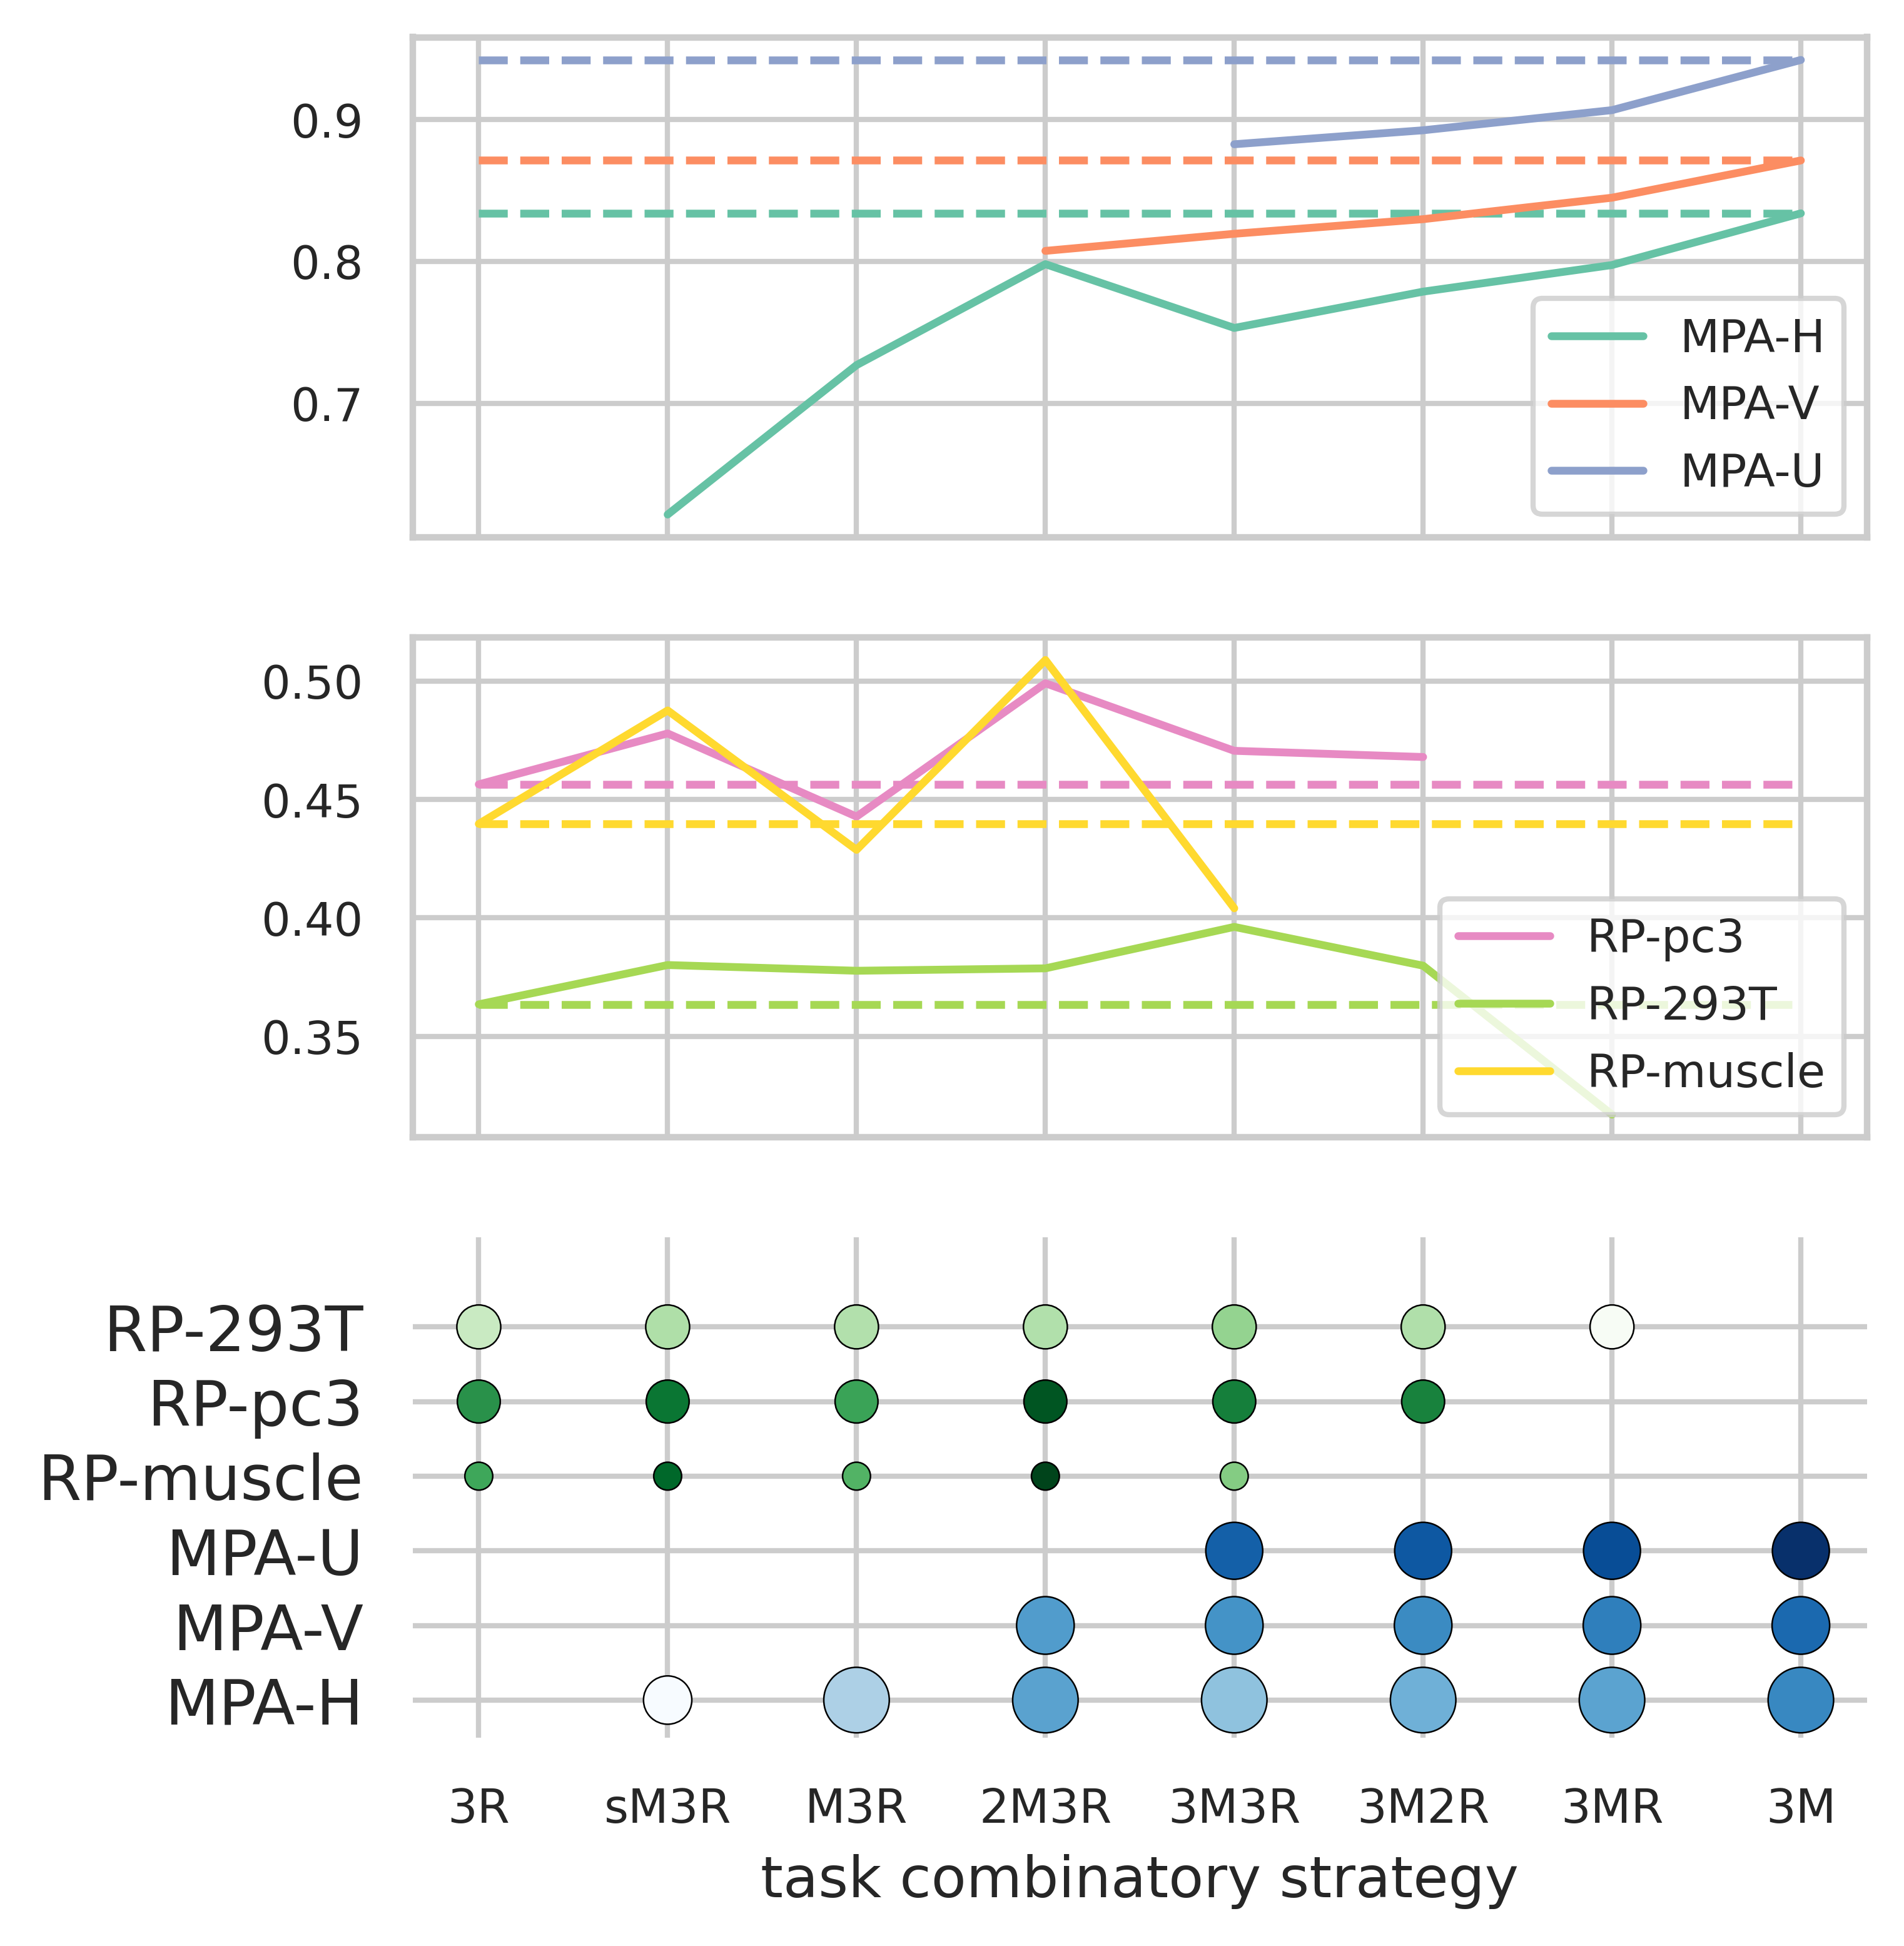

In [79]:
sns.set_theme(style="whitegrid",font_scale=0.8)

fig,axs = plt.subplots(3,1,figsize=(5,6),sharex=True,dpi=600)

ax0 = axs[0]
i=0
for col in ['MPA-H','MPA-V','MPA-U']:
    ax0.plot(range(8),toplot[col].values,label=col,color=color_list[i])
    end = toplot[col].values[-1]
    ax0.plot([0,7], [end,end],'--',color=color_list[i])
    i+=1

ax1 = axs[1]
for col in ['RP-pc3','RP-293T','RP-muscle']:
    ax1.plot(range(8),toplot[col].values,label=col,color=color_list[i])
    RP_end = toplot[col].values[0]
    ax1.plot([0,7],[RP_end,RP_end],'--',color=color_list[i])
    i+=1


for ax in [ax0,ax1]:
    ax.legend() 
    ax.set_xticklabels([])

ax2 = axs[2]

coordinate = np.where(data_usage >= 0)
c_RP = np.where(c2 > 0.62, np.nan, c2)
cor_dot1 = ax2.scatter(coordinate[0], coordinate[1] , s = np.log(data_usage.flatten('C') + 1)**3*0.08 , linewidth=0.3, 
                      edgecolors='black',c=c_RP,cmap='Greens')

c_MPA = np.where(c2 < 0.62, np.nan, c2)
cor_dot2 = ax2.scatter(coordinate[0], coordinate[1] , s = np.log(data_usage.flatten('C') + 1)**3*0.08 , linewidth=0.3, 
                      edgecolors='black',c=c_MPA,cmap='Blues')


ax2.set_xlabel('task combinatory strategy', fontsize=11)
ax2.set_ylim(-0.5,6.2)
ax2.set_xticks(range(8))
ax2.set_xticklabels(model_order,
                    minor=False, fontsize=9)
# ax2.set_xticklabels(['']*8)
ax2.set_yticks(range(6))
ax2.set_yticklabels(column_order,fontsize=12)
# ax2.set_ylabel('task',fontsize=11)
sns.despine(left=True, bottom=True, ax=ax2)

In [74]:
np.where(c2)

array([       nan,        nan,        nan, 0.43972312, 0.45642205,
       0.36350631, 0.621623  ,        nan,        nan, 0.48763371,
       0.47792088, 0.38009358, 0.72692668,        nan,        nan,
       0.42875289, 0.44279857, 0.37767943, 0.79810664, 0.80745065,
              nan, 0.50894329, 0.49913069, 0.37869585, 0.75314612,
       0.81950111, 0.88259829, 0.40407064, 0.47058667, 0.39620202,
       0.77872801, 0.82980268, 0.89245636,        nan, 0.46797129,
       0.37982002, 0.7974807 , 0.84493828, 0.90663756,        nan,
              nan, 0.31691436, 0.83391882, 0.87119518, 0.94202088,
              nan,        nan,        nan])

## the influence of task weight

In [156]:
M3R3_df = recombine_df.query('`model`=="3M3R"')

In [166]:
M3R3_df=M3R3_df.melt(id_vars=['configuration','weigth_M/R','model'],var_name=['task'])

In [168]:
M3R3_df.loc[:,'tech'] = M3R3_df['task'].apply(lambda x: x.split("-")[0])

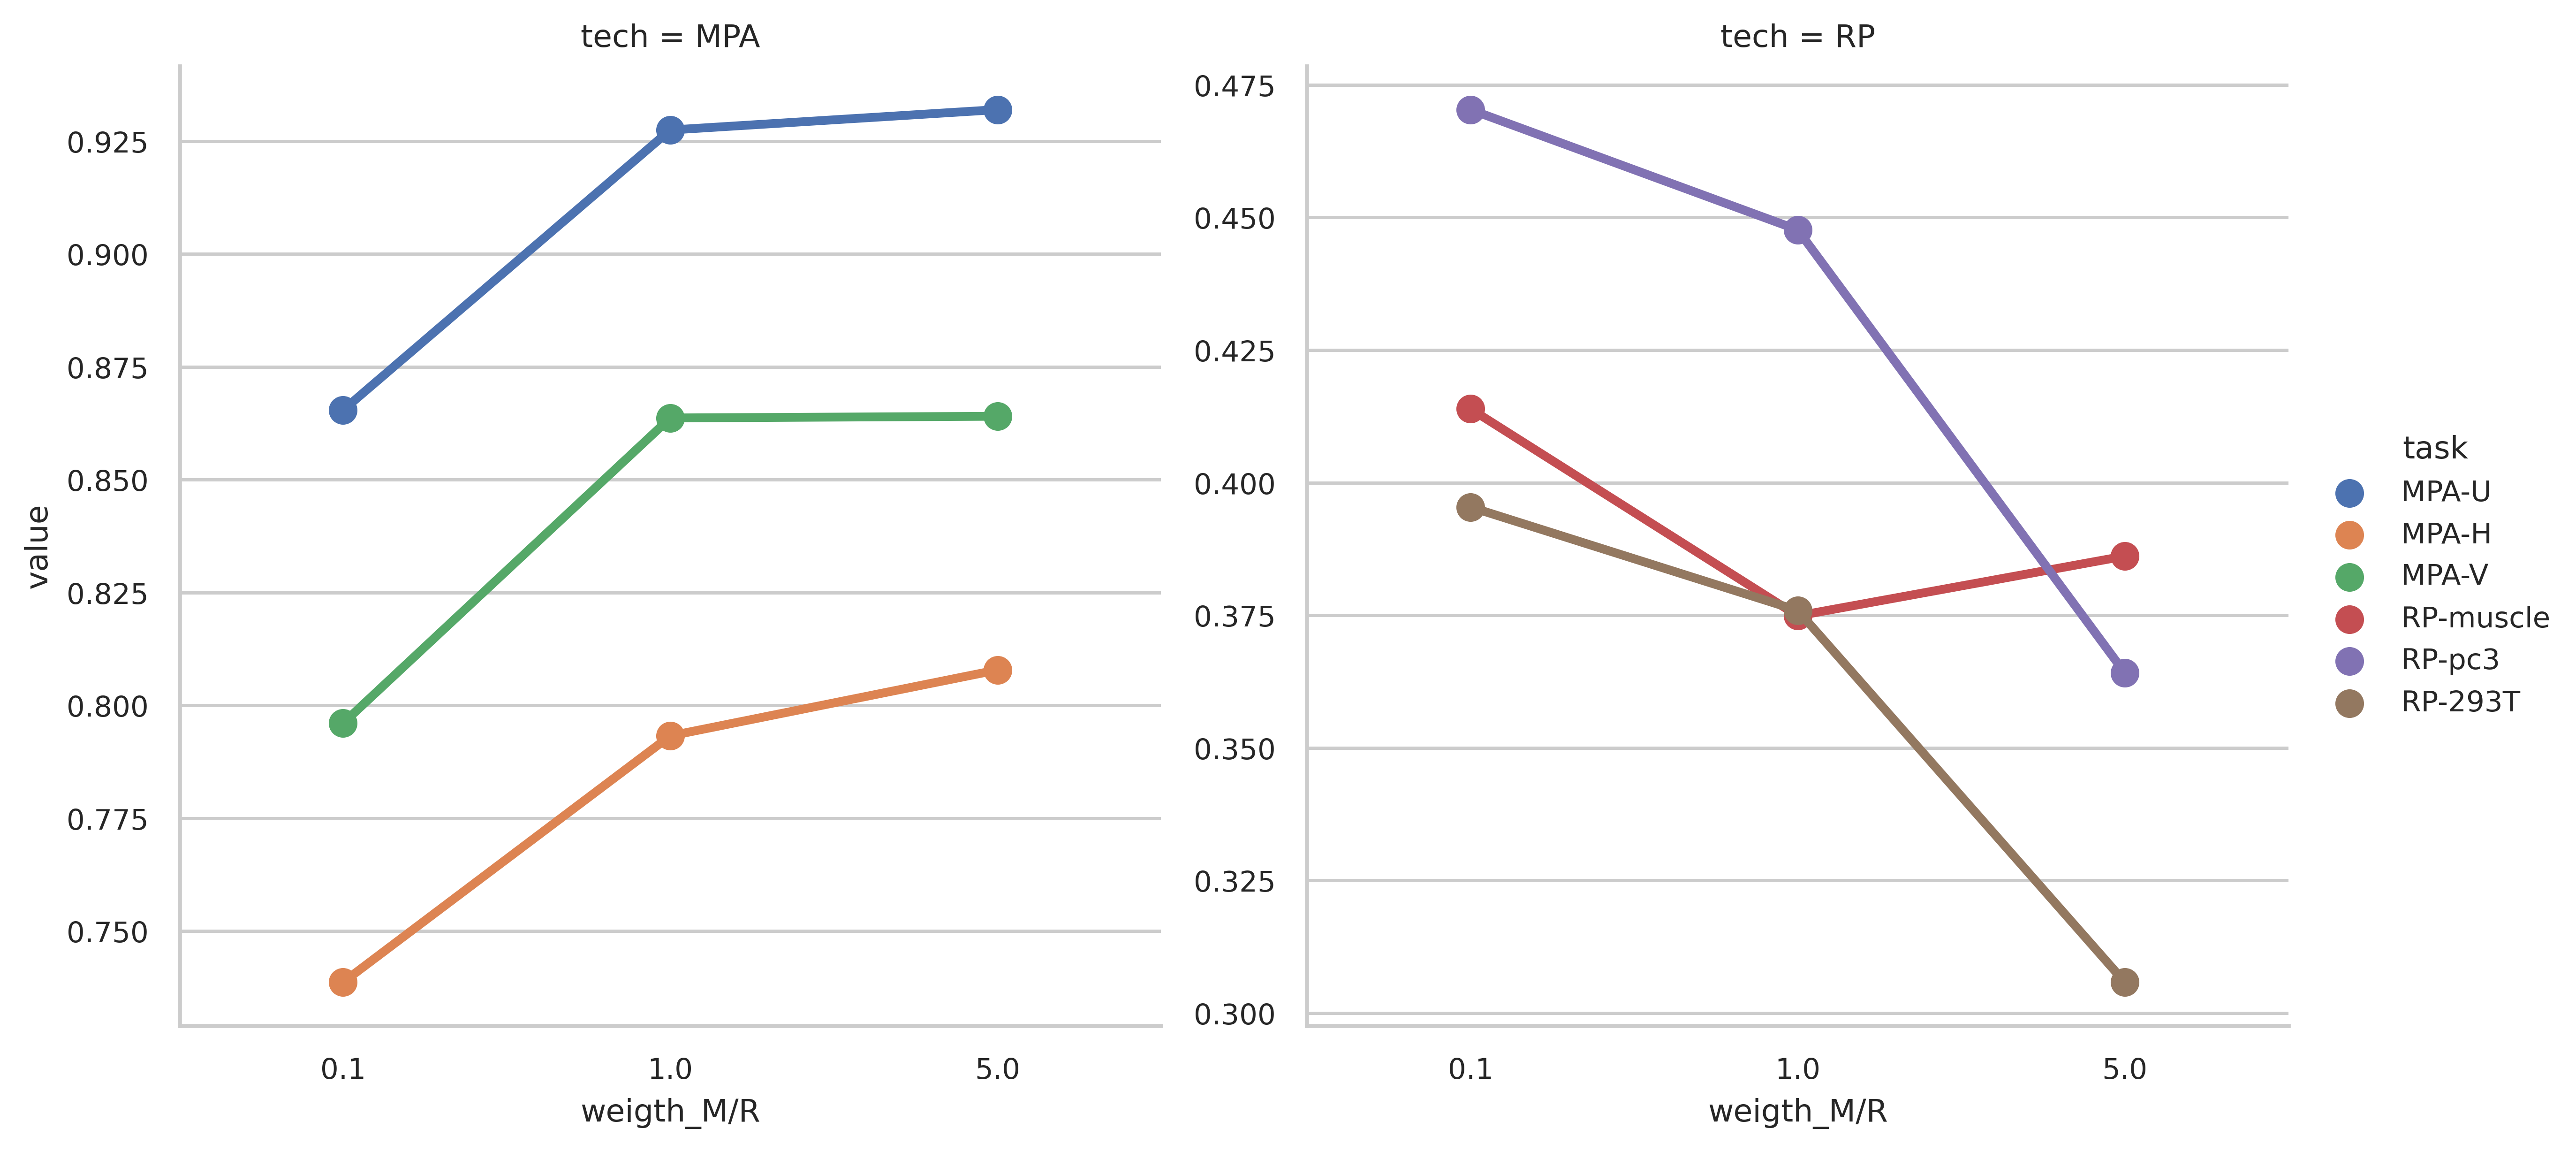

In [181]:
plt.rcParams['figure.dpi']=500
sns.catplot(data=M3R3_df, x='weigth_M/R',y='value',kind='point',col='tech',hue='task',sharey=False);

In [193]:
poolall_df=recombine_df.query('`model`=="3M3R"')

In [ ]:
poolall_df.iloc[:,:6].mean(axis=1)

4    0.613291
5    0.630480
6    0.610000
dtype: float64

In [196]:
poolall_df.loc[:,'overall-perform'] = poolall_df.iloc[:,:6].mean(axis=1).values

/ssd/users/wergillius/.conda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


## come up with a score to rank the combination

- the mean of Relative Performance of each technique

In [89]:
baseline = list(toplot.loc['3M'].values[:3]) + list(toplot.loc['3R'].values[-3:])

baseline

[0.8339188236555583,
 0.871195184235946,
 0.9420208750519716,
 0.4397231161585958,
 0.4564220489350763,
 0.363506308027195]

In [92]:
relative_performance = pd.DataFrame(toplot.values/baseline, 
                                    columns=toplot.columns)

In [161]:
c_rp = relative_performance.loc['sM3R'].values
c_rp[0:1].mean()+ c_rp[3:].mean() + np.sum(c_rp>0)/6

2.479320729687458

In [162]:
c_rp = relative_performance.loc['M3R'].values
c_rp[0:1].mean()+ c_rp[3:].mean() + np.sum(c_rp>0)/6

2.5330974190916953

In [163]:
c_rp = relative_performance.loc['2M3R'].values
c_rp[0:2].mean()+ c_rp[3:].mean() + np.sum(c_rp>0)/6

2.872868751687766

In [164]:
c_rp = relative_performance.loc['3M3R'].values
c_rp[:3].mean()+ c_rp[3:].mean() + np.sum(c_rp>0)/6

2.9402079954401037

In [165]:
c_rp = relative_performance.loc['3M2R'].values
c_rp[:3].mean()+ c_rp[4:].mean() + np.sum(c_rp>0)/6

2.812988010365336

In [166]:
c_rp = relative_performance.loc['3MR'].values
c_rp[:3].mean()+ c_rp[5:].mean() + np.sum(c_rp>0)/6

2.501361292640341

In [212]:
performance_score=np.array([2.5, 2.479320729687458,2.5330974190916953,2.872868751687766,2.9402079954401037,2.812988010365336,2.501361292640341,2.5])/3

In [213]:
relative_performance.loc[:,'overall_performance'] = performance_score

In [241]:
5/18

0.2777777777777778

In [242]:
1/3

0.3333333333333333

In [23]:
relative_performance

,MPRA-H,MPRA-V,MPRA-U,RP-muscle,RP-pc3,RP-293T,overall_performance
model,,,,,,,
3R,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.833333
sM3R,0.745424,NaN,NaN,1.108956,1.047103,1.045631,0.826440
M3R,0.871700,NaN,NaN,0.975052,0.970152,1.038990,0.844366
2M3R,0.957056,0.926831,NaN,1.157418,1.093573,1.041786,0.957623
3M3R,0.903141,0.940663,0.936920,0.918921,1.031034,1.089945,0.980069
3M2R,0.933818,0.952488,0.947385,NaN,1.025304,1.044879,0.937663
3MR,0.956305,0.969861,0.962439,NaN,NaN,0.871826,0.833787
3M,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.833333


In [214]:
relative_performance.to_csv("Fig_3D_result_April28.csv",index=True)

In [4]:
relative_performance = pd.read_csv("Fig_3D_result_April28.csv",index_col=0)

In [8]:
relative_performance.rename(
    {col:col.replace("MPA","MPRA") for col in relative_performance.columns if "MPA" in col},
    axis=1, inplace=True
)

In [25]:
column_order = [col.replace("MPA","MPRA") for col in column_order]

/tmp/ipykernel_4157/884295865.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([""]*8)


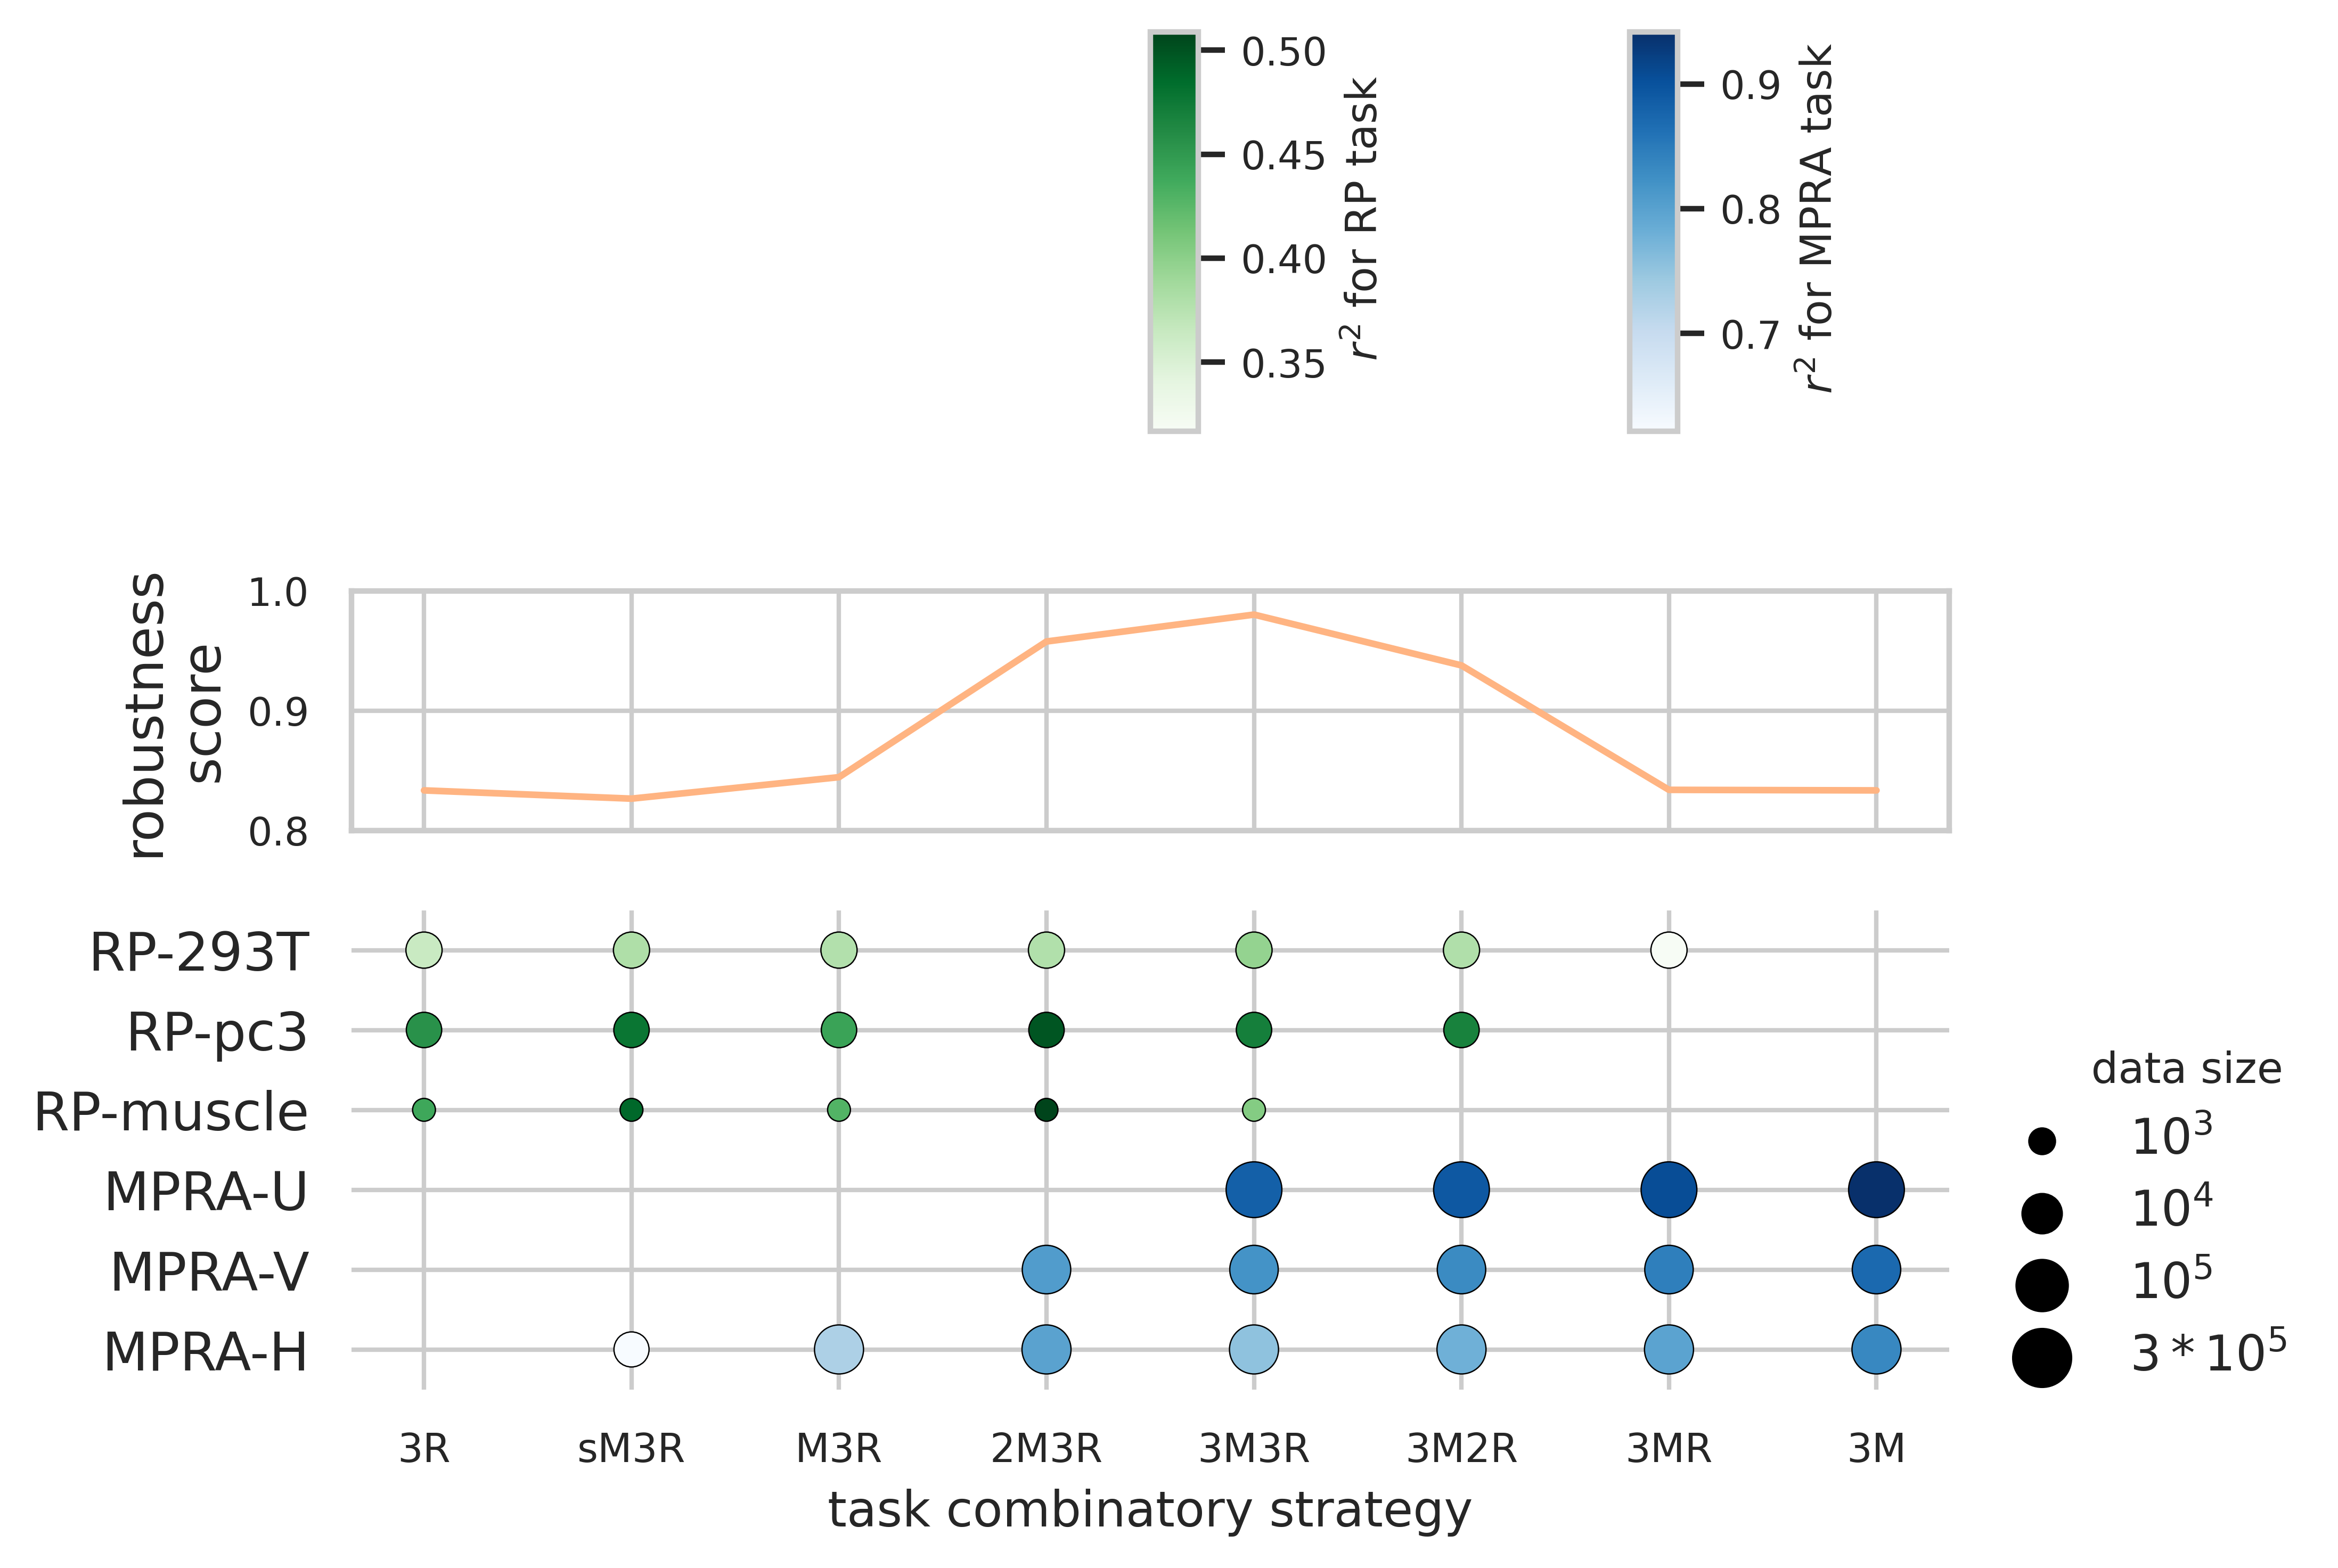

In [26]:
sns.set_theme(style="whitegrid",font_scale=0.8)
fig = plt.figure(figsize=(5,2.5), dpi=600)

ax1 = fig.add_axes([0,0.7,1,0.3])
ax2 = fig.add_axes([0,0,1,0.6])

ax1.plot(relative_performance['overall_performance'].values, color=sns.color_palette("pastel",2)[1])
ax1.set_xticklabels([""]*8)
ax1.set_xlabel('')
ax1.set_ylabel("robustness\nscore",fontsize=12)

ax1.set_ylim(0.8,1)
# sns.despine(ax=ax1)
# plot the heat map


coordinate = np.where(data_usage >= 0)
c_RP = np.where(c2 > 0.62, np.nan, c2)
cor_dot1 = ax2.scatter(coordinate[0], coordinate[1] , s = np.log(data_usage.flatten('C') + 1)**3*0.08 , linewidth=0.3, 
                      edgecolors='black',c=c_RP,cmap='Greens')

c_MPA = np.where(c2 < 0.62, np.nan, c2)
cor_dot2 = ax2.scatter(coordinate[0], coordinate[1] , s = np.log(data_usage.flatten('C') + 1)**3*0.08 , linewidth=0.3, 
                      edgecolors='black',c=c_MPA,cmap='Blues')


ax2.set_xlabel('task combinatory strategy', fontsize=11)
ax2.set_ylim(-0.5,6.2)
ax2.set_xticks(range(8))
ax2.set_xticklabels(model_order,
                    minor=False, fontsize=9)
# ax2.set_xticklabels(['']*8)
ax2.set_yticks(range(6))
ax2.set_yticklabels(column_order,fontsize=12)
# ax2.set_ylabel('task',fontsize=11)
ax2.set_ylim(-0.5,5.5)
sns.despine(left=True, bottom=True, ax=ax2)

cax = fig.add_axes([0.5, 1.2,  0.03, 0.5])
# fig.colorbar(cor_dot, use_gridspec=False, orientation='horizontal', cax=cax )
cbar=plt.colorbar(cor_dot1, use_gridspec=False, shrink=1, cax=cax, )
cbar.set_label('  '+r'$r^2$ for RP task')

cax2 = fig.add_axes([0.8, 1.2,  0.03, 0.5])
# fig.colorbar(cor_dot, use_gridspec=False, orientation='horizontal', cax=cax )
cbar2=plt.colorbar(cor_dot2, use_gridspec=False, shrink=1, cax=cax2,)
cbar2.set_label('  '+r'$r^2$ for MPRA task')

## create legend
gll = ax2.scatter([],[], s=28, marker='o', color='black')
gl = ax2.scatter([],[], s=70, marker='o', color='black')
gm = ax2.scatter([],[], s=122, marker='o', color='black')
ga = ax2.scatter([],[], s=158, marker='o', color='black')

ax2.legend((gll,gl,gm, ga),
       (r'$10^3$', r'$10^4$', r'$10^5$',r'$3*10^5$'),
       scatterpoints=1,
       bbox_to_anchor = (1, 0.8),
       frameon=False,
       ncol=1,
       title='       data size',
       fontsize=11);